# Data preparation

In [1]:
import json
from src.ingestion.download_related_paper_datasets import download_related_paper_datasets
from src.ingestion.download_samples import download_samples
import seaborn as sns
from wordcloud import WordCloud
from io import StringIO
import matplotlib.pyplot as plt
from src.analysis.analyzer import DatasetAnalyzer
from src.visualization.visualize_clusters import visualize_clusters_jupyter
from src.visualization.get_topic_table import get_topic_table
import aiohttp
import asyncio
import pandas as pd
import itertools
import spacy
import scispacy
from scispacy.linking import EntityLinker

{"asctime": "2025-06-05 16:30:07,349", "levelname": "INFO", "message": "Registering at the factory, space: dummy distance type: INT"}
{"asctime": "2025-06-05 16:30:07,350", "levelname": "INFO", "message": "Registering at the factory, space: dummy distance type: FLOAT"}
{"asctime": "2025-06-05 16:30:07,350", "levelname": "INFO", "message": "Registering at the factory, space: bit_hamming distance type: INT"}
{"asctime": "2025-06-05 16:30:07,350", "levelname": "INFO", "message": "Registering at the factory, space: bit_jaccard distance type: FLOAT"}
{"asctime": "2025-06-05 16:30:07,351", "levelname": "INFO", "message": "Registering at the factory, space: leven distance type: INT"}
{"asctime": "2025-06-05 16:30:07,351", "levelname": "INFO", "message": "Registering at the factory, space: normleven distance type: FLOAT"}
{"asctime": "2025-06-05 16:30:07,351", "levelname": "INFO", "message": "Registering at the factory, space: kldivfast distance type: FLOAT"}
{"asctime": "2025-06-05 16:30:07,3

In [2]:
paper_export = json.load(open("GEO_Datasets/pubmed-hallmarks-of-aging-an-expanding-universe.json"))
datasets = download_related_paper_datasets(paper_export)
print(len(datasets))

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/src/ingestion/download_related_paper_datasets.py:15: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(paper_export["df"])


195


# Dataset metadata

## Experiment types

In [3]:
experiment_types = [dataset.experiment_type for dataset in datasets]
print(experiment_types[0:10])

['Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Other', 'Other', 'Other', 'Expression profiling by high throughput sequencing', 'Methylation profiling by genome tiling array', 'Methylation profiling by genome tiling array', 'Other']


/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


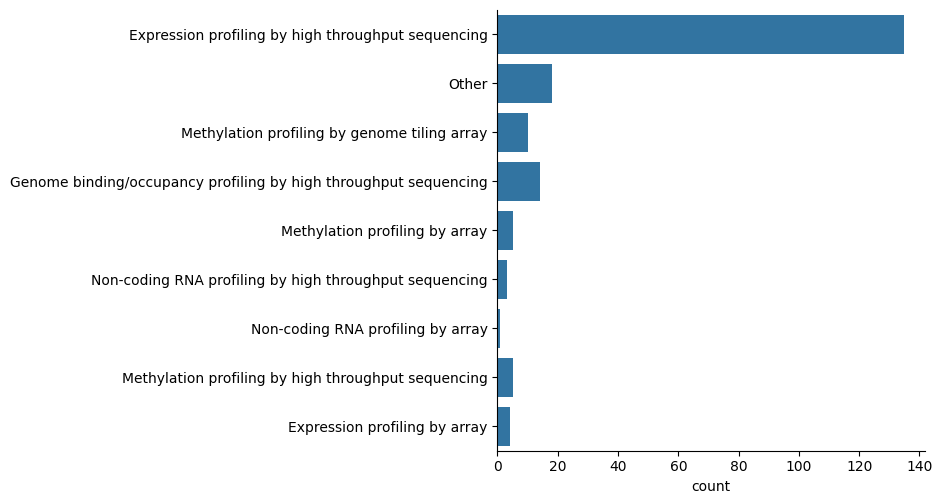

In [4]:
sns.catplot(experiment_types, kind="count")

Most experiments are done through expression profiling by high throughput sequencing.

## Organisms

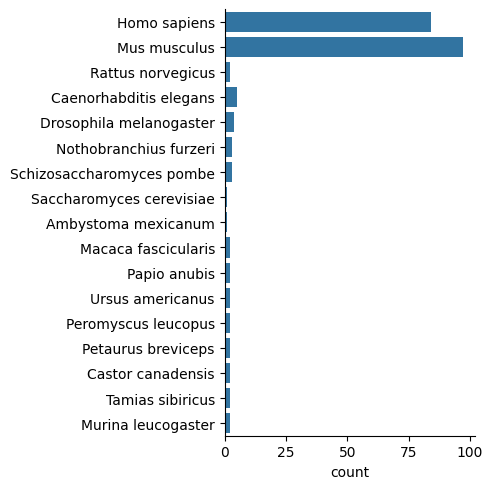

In [5]:
organisms = [organism for dataset in datasets for organism in dataset.organisms]
sns.catplot(organisms, kind="count")

Most datasets are collected from either mice or people.

In [6]:
## Title wordcolud

In [7]:
from typing import List
def plot_wordcloud(strings: List[str]):
    """
    Plots a wordcloud of a list of strings.
    """
    si = StringIO()
    for string in strings:
        si.write(string)
    text = si.getvalue()
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(background_color="white",max_words=len(text),max_font_size=40,).generate(text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

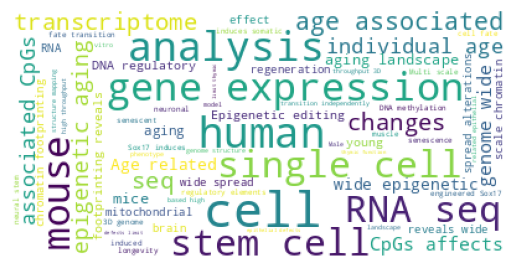

In [8]:
plot_wordcloud([dataset.title for dataset in datasets])

## Summary wordcolud

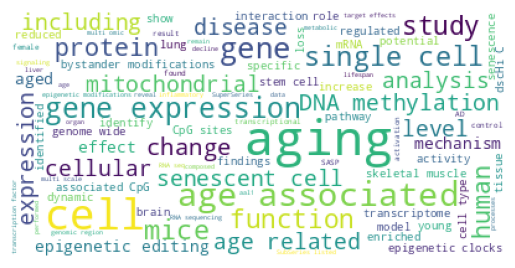

In [9]:
plot_wordcloud([dataset.summary for dataset in datasets])


## Overall design wordcolud

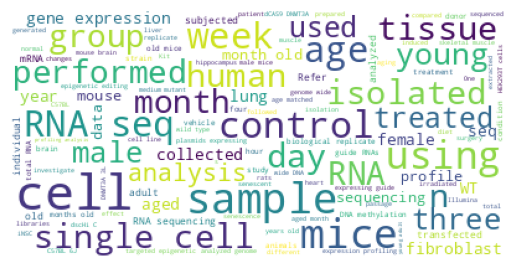

In [10]:
plot_wordcloud([dataset.overall_design for dataset in datasets])

## Platform ID counts

<Figure size 1000x2000 with 0 Axes>

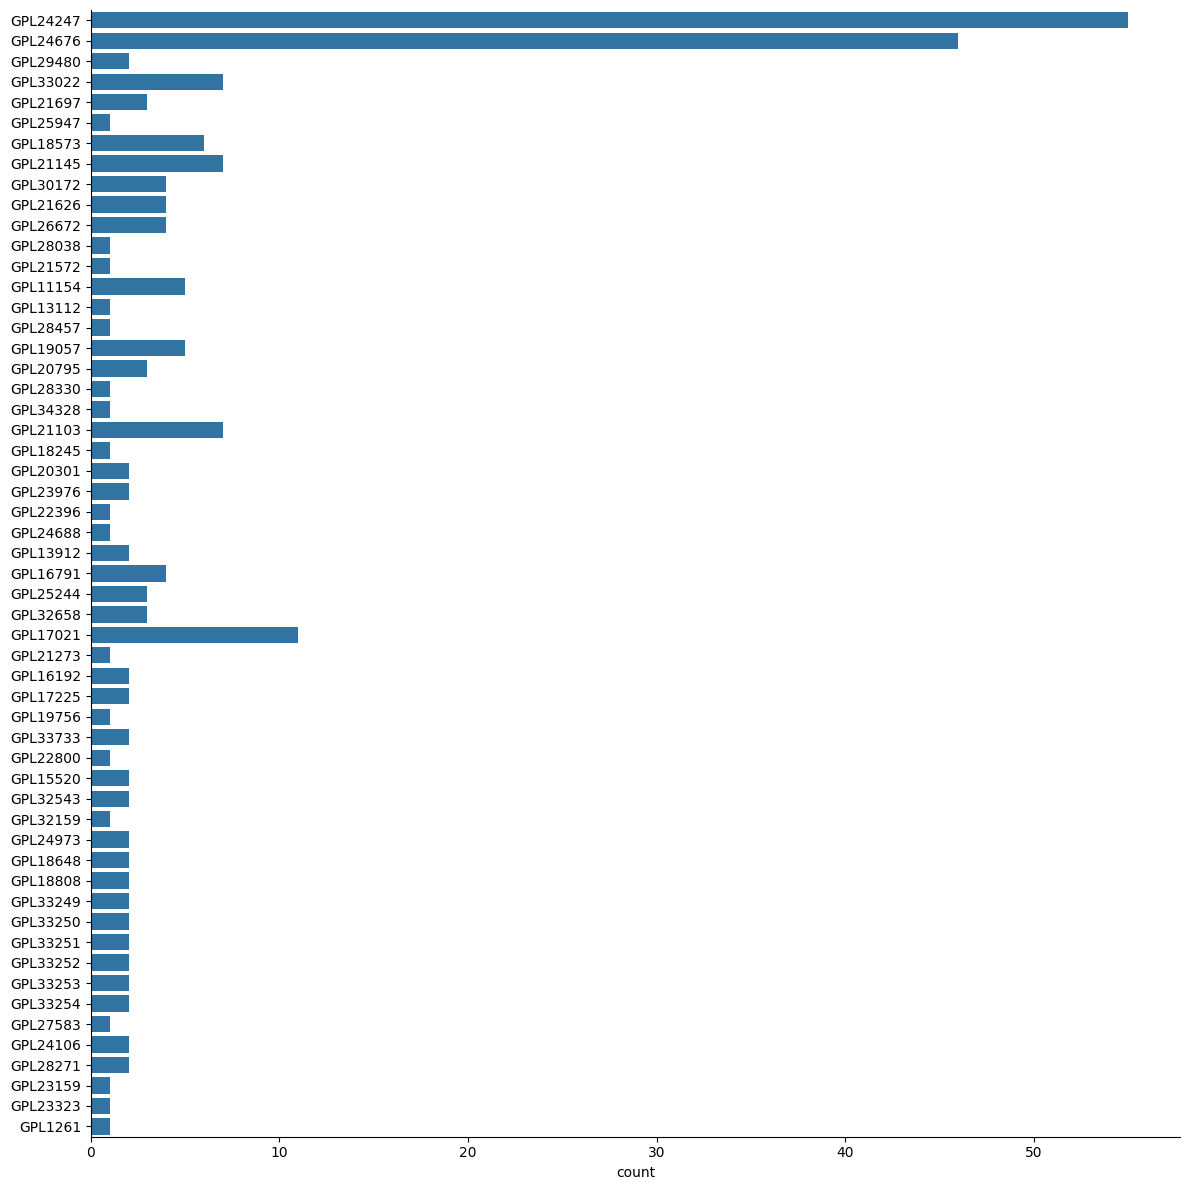

In [11]:
platform_ids = [platform_id for dataset in datasets for platform_id in dataset.platform_ids]
plt.figure(figsize=(10, 20))
sns.catplot(platform_ids, kind="count", height=12)
plt.show()

The top two platform IDs correspond to the Illumina Nova Seq 6000 sequencer. There is one platform record for when it is used and people and another one for mice. This is not surprising as Illumina sequencers are widely used in genomics research.

# Clustering

In [12]:
svd_dimensions = 15
topic_words = 10
best_result = None
best_score = 9999999
best_n_clusters = None

for n_clusters in range(5, 25):
    analyzer = DatasetAnalyzer(svd_dimensions, n_clusters)
    result = analyzer.analyze_datasets(datasets)
    if result.silhouette_score < best_score:
        best_score = result.silhouette_score
        best_result = result
        best_n_clusters = n_clusters

print(f"Best number of clusters {best_n_clusters}")

{"asctime": "2025-06-05 16:30:12,464", "levelname": "INFO", "message": "Explained variance of the SVD step: 32.2 %"}
{"asctime": "2025-06-05 16:30:12,481", "levelname": "INFO", "message": "Silhouette score: 0.22720326082716105"}
{"asctime": "2025-06-05 16:30:12,483", "levelname": "INFO", "message": "Clustering time: 0.01s"}
{"asctime": "2025-06-05 16:30:12,863", "levelname": "INFO", "message": "Explained variance of the SVD step: 32.2 %"}
{"asctime": "2025-06-05 16:30:12,872", "levelname": "INFO", "message": "Silhouette score: 0.20103014838022135"}
{"asctime": "2025-06-05 16:30:12,873", "levelname": "INFO", "message": "Clustering time: 0.01s"}
{"asctime": "2025-06-05 16:30:13,271", "levelname": "INFO", "message": "Explained variance of the SVD step: 32.2 %"}
{"asctime": "2025-06-05 16:30:13,281", "levelname": "INFO", "message": "Silhouette score: 0.23868926768990176"}
{"asctime": "2025-06-05 16:30:13,283", "levelname": "INFO", "message": "Clustering time: 0.01s"}
{"asctime": "2025-06-0

Similar datasets are located close to each other.
The color of a point represnts the topic of the dataset.

In [13]:
visualize_clusters_jupyter(best_result.df, best_result.cluster_topics)

Loading BokehJS ...

## Topics

In [14]:
topic_table = get_topic_table(best_result.cluster_topics, best_result.df)
topic_df = pd.DataFrame(topic_table, columns=["#", "Datasets", "Color", "Topics"])
topic_df = topic_df.set_index("#")
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# Apply styling to the 'color' column
topic_df = topic_df[["Color", "Datasets", "Topics"]].style.map(lambda x: f"background-color: {x};" if type(x) == str and x.startswith("#") else "")\
    .map(lambda x: f"color: {x};" if type(x) == str and x.startswith("#") else "")
topic_df

,Color,Datasets,Topics
#,,,
1,#1f77b4,54,"single, chromatin, reprogramming, changes, multi, structure, using, binding, dschi, associated"
2,#ff7f0e,45,"mitochondrial, lifespan, human, hair, related, years, non, analysis, metabolic, lung"
3,#2ca02c,45,"brain, mice, aged, old, young, mouse, analysis, musculus, month, senescence"
4,#d62728,24,"epigenetic, methylation, age, dna, editing, cpgs, modifications, wide, genome, associated"
5,#9467bd,14,"senescent, senescence, sasp, acss2, stress, er, promotes, complex, phenotype, hira"
6,#8c564b,13,"muscle, skeletal, dnmt3a, hypercapnia, mice, biopsies, autophagy, tg, sarcopenia, healthy"


# Sample metadata

In [15]:
# Download samples
samples = set() # We are using a set because some samples can occur twice. For example, a sample appears twice when it is in a subseries and superseries
async with aiohttp.ClientSession() as session:
    for series in datasets:
        series.samples = await download_samples(series, session)
        samples.update(series.samples)

accessions = [sample.accession for sample in samples]
assert len(set(accessions)) == len(samples)

## Number of samples

In [16]:
len(samples)

3931

## Most common sample types

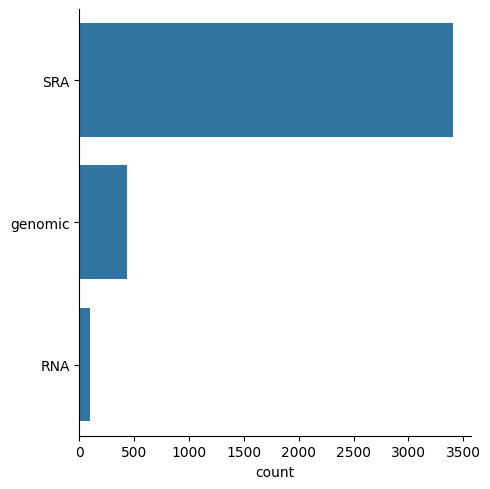

In [17]:
sample_types = [sample.sample_type for sample in samples]
sns.catplot(sample_types, kind="count")

## Most common characteristics keys

Text(0.5, 1.0, 'Most common characterisitics keys')

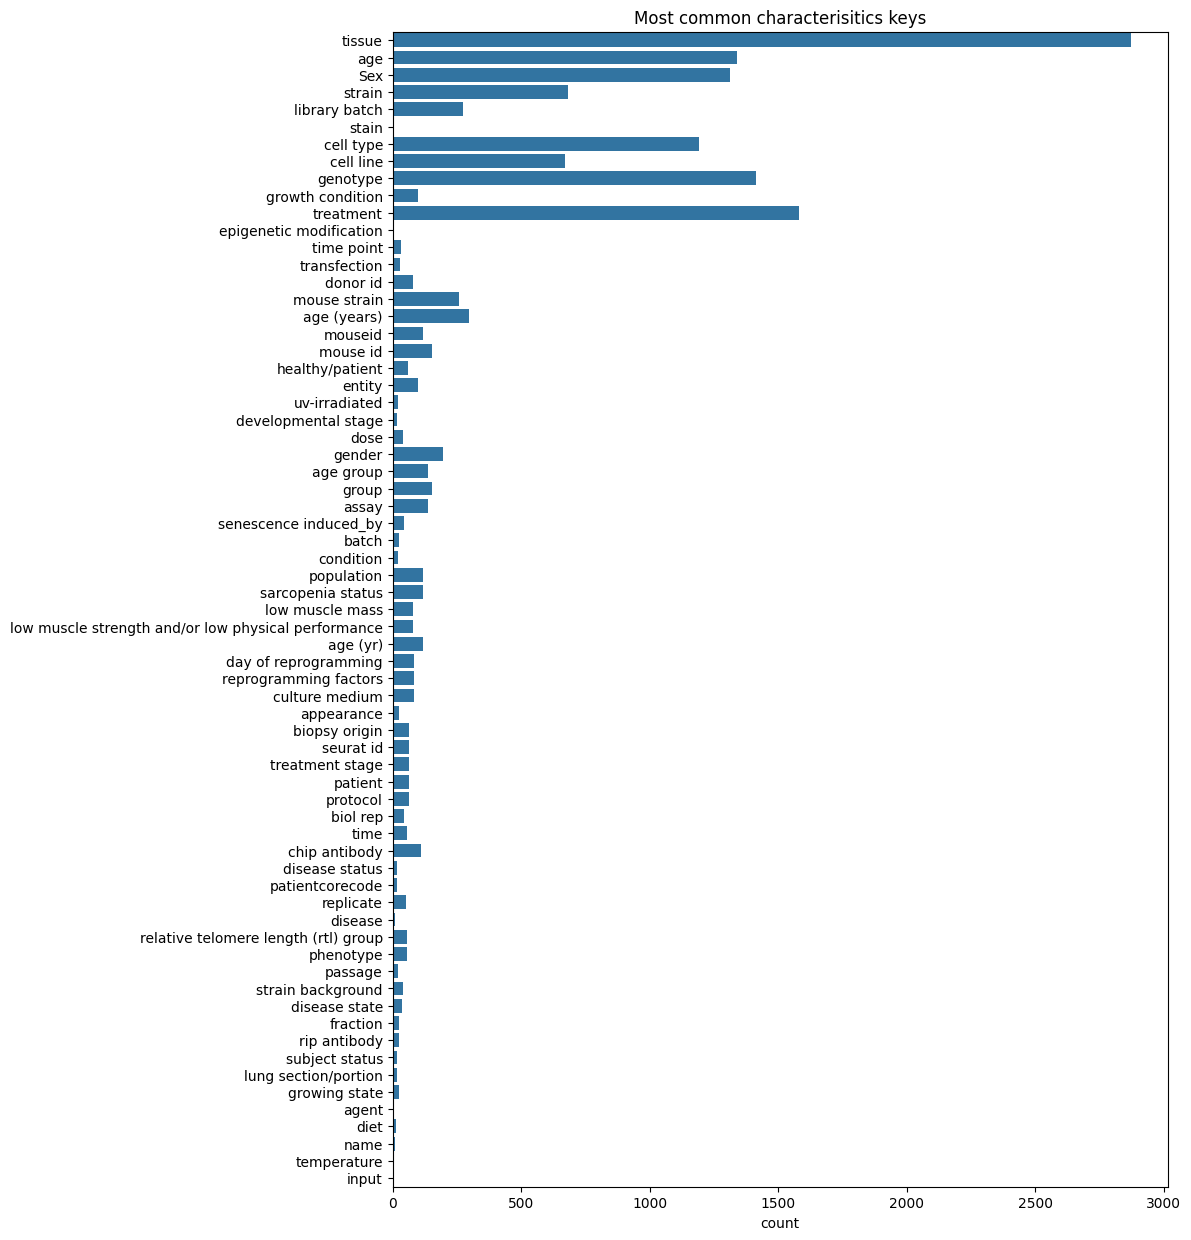

In [18]:
characteristics_keys = [key for sample in samples for key in sample.characteristics]
fig, ax = plt.subplots(figsize=(10, 15))
sns.countplot(characteristics_keys, ax=ax)
ax.set_title("Most common characterisitics keys")

In [19]:
pd.Series(characteristics_keys).value_counts().head(10)

tissue           2871
treatment        1580
genotype         1413
age              1339
Sex              1313
cell type        1192
strain            683
cell line         672
age (years)       297
library batch     275
Name: count, dtype: int64

## Number of samples that have data tables

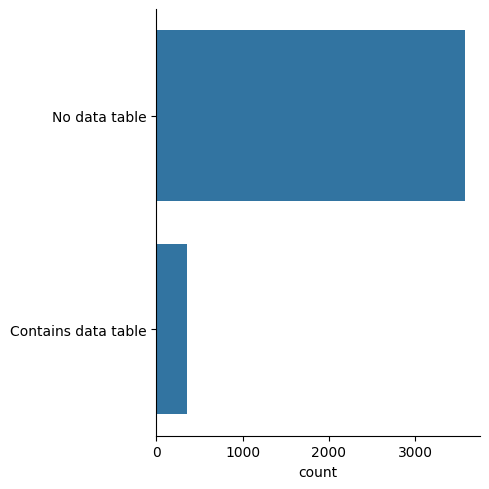

In [20]:
contains_data_table = ["Contains data table" if sample.metadata["data_row_count"][0] != "0" else "No data table" for sample in samples]
sns.catplot(contains_data_table, kind="count")

It seems that relatively few samples have data tables. Therefore, most data is raw sequencing data. 

## Most common tissues

Text(0.5, 1.0, 'Number of samples per tissue')

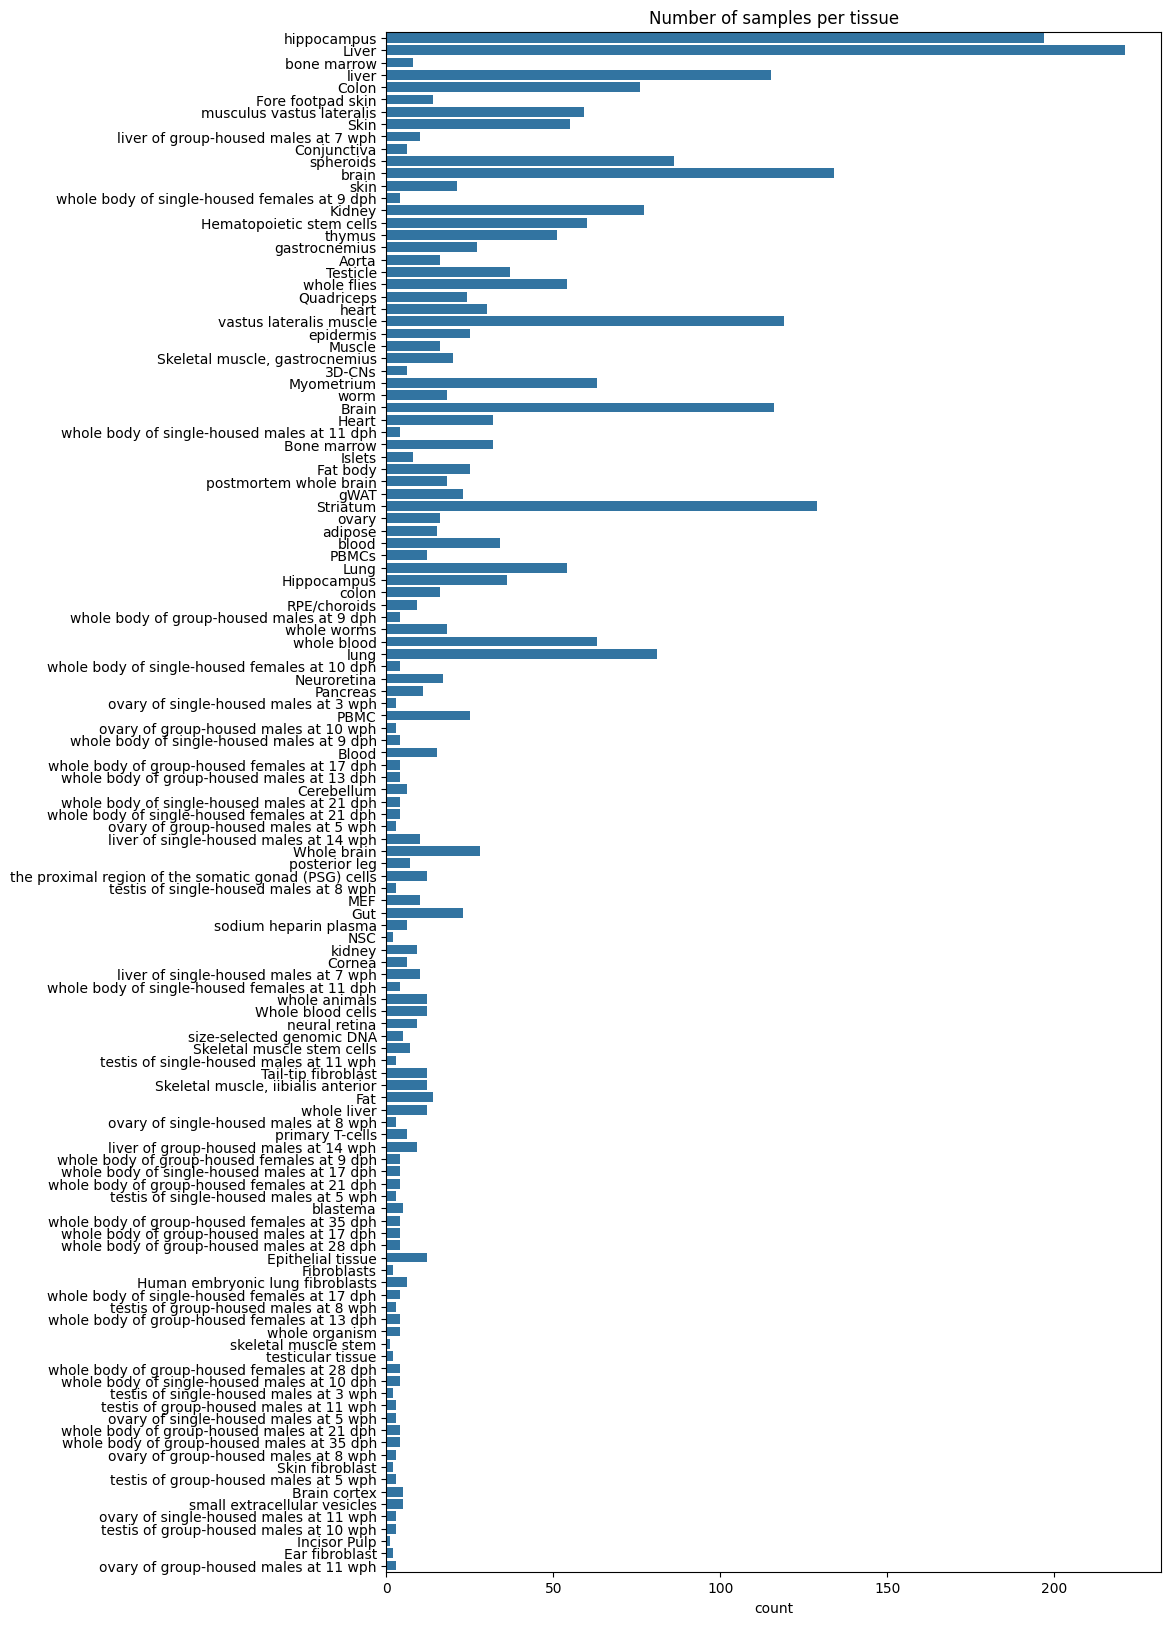

In [21]:
tissues = [sample.characteristics["tissue"] for sample in samples if "tissue" in sample.characteristics]
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(tissues, ax=ax)
ax.set_title("Number of samples per tissue")

There are different names for the same tissue depending on how specific the author wanted to be. Let's try grouping the synonyms together.

The following groupings were obtained using LLama.3.3-70B with the following prompt:

Here is a list of tissue names as extracted from Gene Expression Omnibus sample records. There are different names for the same kind of tissue in the list. Group the synonymous tissue names and give the group a meaningful name. If there are no synonyms for a tissue type create a new group for each such tissue ("<tissue>": ["<tissue>"]). Do not create a category name like "Other". Make sure every item in the list is covered.

Output a JSON where the keys are the group names and the values are the synonyms in that group.

List of tissue names: \<python list of tissue names\>

In [22]:
synonym_groups = \
{
    "Fibroblasts": [
        "Dermal Fibroblast",
        "Fibroblast",
        "Fibroblasts",
        "Human Fibroblast",
        "Human embryonic lung fibroblasts",
        "Mouse embryonic fibroblast",
        "Mouse embryonic fibroblasts",
        "old fibroblasts",
        "Primary lung fibroblasts"
    ],
    "Neural Stem Cells": [
        "fetal primary NSC",
        "miNSC",
        "NSC",
        "old NSC",
        "old miNSC",
        "Primary neural stem cells"
    ],
    "Lung Cells": [
        "Lung cells",
        "mix cell types from lung"
    ],
    "Hepatocytes": [
        "hepatoma cell",
        "Hepatocyte",
        "hepatocellular carcinoma",
        "liver"
    ],
    "Mesenchymal Stromal Cells": [
        "Mesenchymal stromal cell",
        "Mesenchymal stromal cells",
        "human Mesenchymal stem cells",
        "mesenchymal stem cells"
    ],
    "Blood Cells": [
        "Bone marrow cells",
        "Bone marrow mononuclear cells",
        "Hematopoietic progenitors",
        "Hematopoietic stem cells",
        "leukocyte",
        "Peripheral mononuclear blood cell"
    ],
    "Stromal Cells": [
        "CD45-PECAM1+ thymic stroma cells",
        "CD45-PDGFRA+ thymic stroma cells",
        "CD45- thymic stroma cells",
        "Normal human primary prostate stromal cells",
        "stroma cells"
    ],
    "Epithelial Cells": [
        "Conjunctival epithelial cell",
        "corneal epithelial cell"
    ],
    "Muscle Cells": [
        "immortalized mouse myoblast",
        "muscle stem",
        "Pax7+ stem cells"
    ],
    "Immune Cells": [
        "Alveolar Macrophages",
        "B lymphoblastoid",
        "B lymphoblastoid, mouse embryonic stem cell",
        "primary T-cells",
        "T lymphocyte cells"
    ],
    "Yeast Cells": [
        "yeast cells"
    ],
    "Cell Culture": [
        "cell culture",
        "mixed cell culture",
        "mixture"
    ],
    "Brain Cells": [
        "astrocytes",
        "brain",
        "brain cells",
        "microglia",
        "neurons",
        "total brain cells"
    ],
    "Embryonic Stem Cells": [
        "mouse embryonic stem cell"
    ],
    "Podocytes": [
        "podocytes"
    ],
    "Leydig Cells": [
        "Leydig cells"
    ],
    "Endothelial Cells": [
        "Endothelial cells isolation(CD31 positive selection)"
    ],
    "Human Neuronal Cells": [
        "Human nueronal cells"
    ],
    "EPC": [
        "EPC"
    ],
    "NPC": [
        "NPC"
    ],
    "FAPs": [
        "FAPs"
    ],
    "MEF": [
        "MEF",
        "MEFs"
    ],
    "Human Embryonic Kidney": [
        "human embryonic kidney"
    ],
    "Dental Pulp Cell": [
        "Dental pulp cell"
    ],
    "Tissue Dissociated Cells": [
        "tissue dissociated cells"
    ],
    "Reprogramming Intermediate": [
        "Reprogramming intermediate"
    ],
    "Etoposide-induced Senescent Cells": [
        "Etoposide-induced senescent (ETIS) cells"
    ],
    "Carcinoma Cells": [
        "Carcinoma, derived from the metastatic site, bone of a prostate cancer patient",
        "Grade IV, adenocarcinoma, derived from the metastatic site, brain of a prostate cancer patient"
    ]
}

tissue_to_group_mapping = {tissue: group for group, tissue_list in synonym_groups.items() for tissue in tissue_list}

In [23]:
mapped_tissues = [tissue_to_group_mapping[tissue] if tissue in tissue_to_group_mapping else tissue for tissue in tissues]

Text(0.5, 1.0, 'Number of samples per tissue (synonyms grouped)')

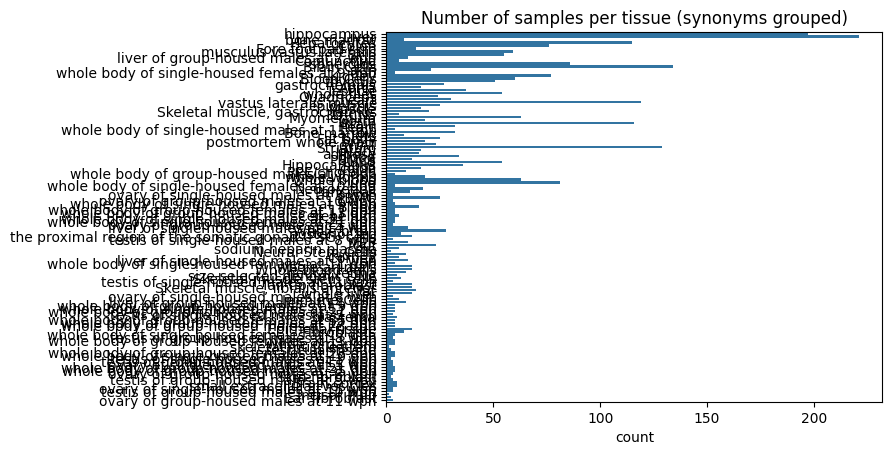

In [24]:
ax = sns.countplot(mapped_tissues)
ax.set_title("Number of samples per tissue (synonyms grouped)")

## Most common cell types

Text(0.5, 1.0, 'Number of samples per cell type')

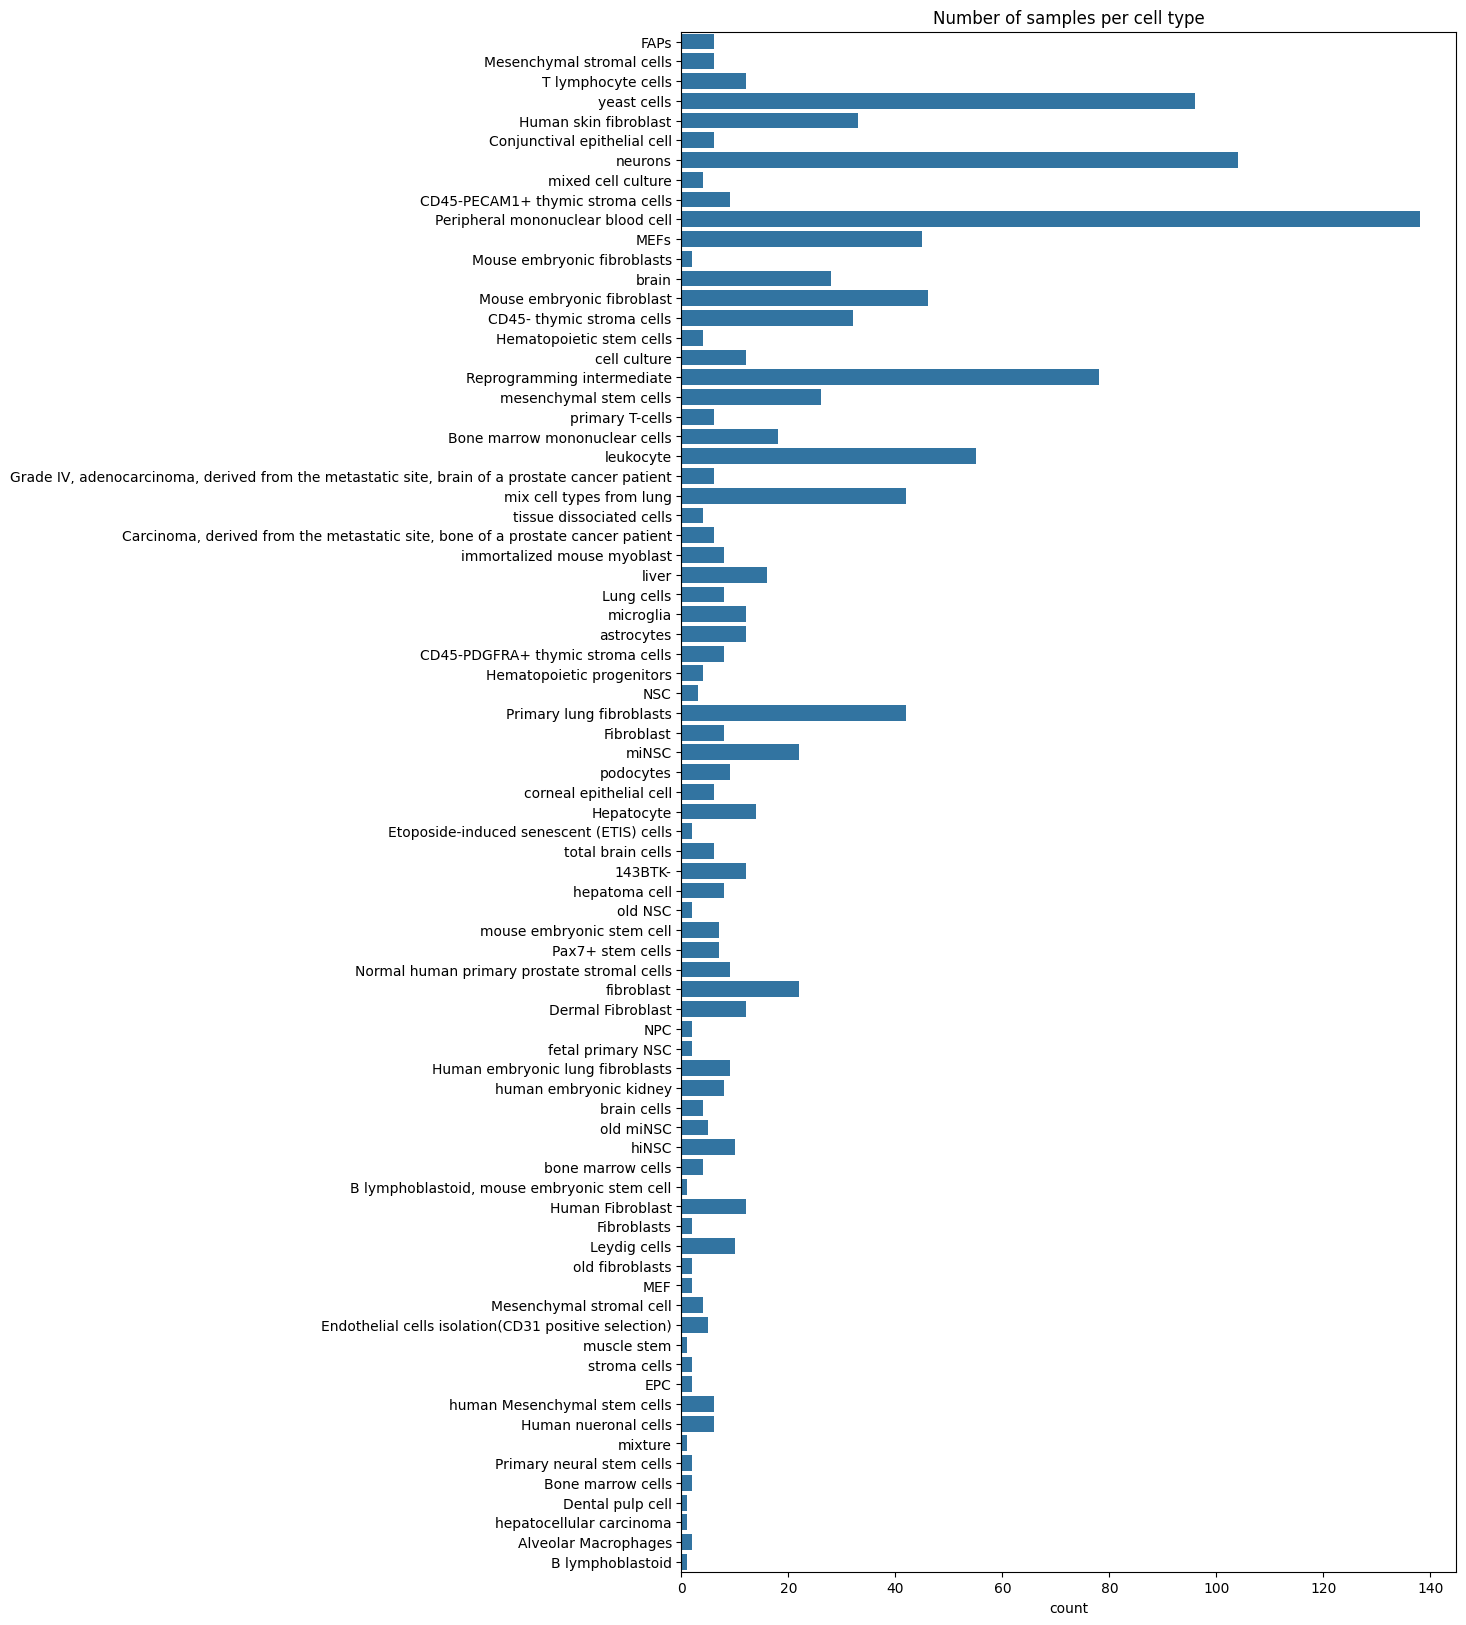

In [25]:
tissues = [sample.characteristics["cell type"] for sample in samples if "cell type" in sample.characteristics]
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(tissues, ax=ax)
ax.set_title("Number of samples per cell type")

There are synonyms here as well.

As a side note, let's see if most samples contain either the tissue type or cell type as both are indicative of the tissue being studied. 

In [26]:
contains_tissue_or_cell_type = [sample for sample in samples if "tissue" in sample.characteristics or "cell type" in sample.characteristics]
n_samples = len(samples)
n_contains = len(contains_tissue_or_cell_type)
print(f"{n_contains}/{n_samples} ({n_contains / n_samples * 100}%) contain tissue information")

3539/3931 (90.02798270160265%) contain tissue information


## Values of other characteristics fields

Time

In [27]:
time_values = [sample.characteristics["time"] for sample in samples if "time" in sample.characteristics]
time_values += [sample.characteristics["time point"] for sample in samples if "time point" in sample.characteristics]
for time in set(time_values):
    print(time)


d0
isolation after 7 days of culture
isolation after 11 days after transfection
d0 (1st Day of adulthood)
isolation after 21 days of culture
isolation after 14 days of culture
7 hours
72 h
isolation after 11 days of culture


Age

In [28]:
age_keys = set([key for key in characteristics_keys if "age" in key.split(" ")])
age_values = []
for age_key in age_keys:
    age_values += [sample.characteristics[age_key] for sample in samples if age_key in sample.characteristics]
print("Keys:", age_keys)
for age_value in set(age_values):
    print(age_value)

Keys: {'age group', 'age (yr)', 'age (years)', 'age'}
70.4
67 years old
11 weeks
24-month-old
76.6
62 years
76.5
69.3
33
Old
68
45 years
males, 10-days-old
71.8
56 years
28 years
73.9
P38
79
70.8
02-month old
110+
62
88
57
24month
69
80
13 weeks
100
75.2
30mo
adult
51
2 Months
41
82
72
Young Adult
27 months
59
Middle
75
29
54
40
1.75
45
76
11.7 weeks
young fertile adults (17-22 years old)
54 years old
73.2
70.3
28
74.2
100-104
61 years
105-109
76.8
0-year-old
30 years
25 years
55
78
Young
24 months
49
11.9 weeks
59 years
27
23 years
85
75.7
81
86
30
40 years
6 months
20-month old
24-month
3 mo
31 years
65
0.5
4 months
64 years
52
3-4 months old
72.2
67 years
49 years
58 years
55 years
74.6
24 months old
68.8
0.666666667
24 Months
65 years
73
P28
Aged
73.5
84
70
15mo
18-month old
75.1
2 mounth
6-month
75.5
22 month
29 years
6 weeks old
9 Months
4 weeks old
24
older adults (>60 years old)
20-22 months old
24mo
70.5
63
43
32
26 years
46 years
15 Months
74
47 years
34
83
26 months
30 Month

## Parsing age fields

Age is usually represented here as a number or range followed by a unit, or just a number.
However there are excpetions to this rule, for example ">60 years old", and they have to be handled differently.
There are also non-numerical descriptions such as Young, Middle and Old which cannot be converted into numbers.

In [29]:
import re
INF_AGE = 999
MIN_AGE = 0


def normalize_to_years(value, unit):
    """Converts age to years based on the unit."""
    unit = unit.lower()
    if unit in ['year', 'years', 'yr', 'yrs', 'y']:
        return float(value)
    elif unit in ['month', 'months', 'mo', 'mos']:
        return float(value) / 12.0
    elif unit in ['week', 'weeks', 'wks', 'wk', 'w']:
        return float(value) / 52.0
    elif unit in ['day', 'days', 'd']:
        return float(value) / 365.0
    return None  # Should not happen if regex is correct


def extract_age(age_str: str):
    """
    Extratcts age in years or a range from a piece of text 
    stating the age or age group.
    If the age cannot be determined, the function returns null.

    :param age_str: Text from which to extract the age
    :returns: A single number containing the age or a pair if a range was detected.
    """
    age_str = str(age_str).lower().strip()  # Normalize text

    if is_number(age_str):
        return float(age_str)  # assume age is in years

    is_age_range, age_range = try_extract_age_range(age_str)
    if is_age_range:
        return age_range

    # Handle 110+
    is_age_plus, age_range = try_extract_age_plus(age_str)
    if is_age_plus:
        return age_range

    # Handle >60
    is_greater_than_age, age_range = try_extract_greater_than_age(age_str)
    if is_greater_than_age:
        return age_range
    
    # Handle <60
    is_less_than_age, age_range = try_extract_less_than_age(age_str)
    if is_less_than_age:
        return age_range

    is_age_plus_unit, age = try_extract_age_plus_unit(age_str)
    if is_age_plus_unit:
        return age

    
    return None


def try_extract_age_range(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-\s*(\d+\.?\d*)\s*(year|yr|month|mo|week|wk|w|day|d)?s?\s*(old)?', age_str)
    if not match:
        return False, None
    val1 = float(match.group(1))
    val2 = float(match.group(2))
    unit = match.group(3)
    if unit:
        return True, (normalize_to_years(val1, unit), normalize_to_years(val2, unit))
    else:
        return True, (val1, val2)  # Assume years


def try_extract_age_plus_unit(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-?\s*(year|yr|month|mo|week|wk|w|day|d)s?\s*-?\s*(old)?', age_str)
    if not match:
        return False, None
    if match:
        value = float(match.group(1))
        unit = match.group(2)
        return True, normalize_to_years(value, unit)


def try_extract_age_plus(age_str: str):
    """
    Tries to extract ages like 110+ out of the text.
    """
    match = re.search(r'(\d+)\+', age_str)
    if not match:
        return False, None
    if match:
        return True, (float(match.group(1)), INF_AGE)


def try_extract_greater_than_age(age_str: str):
    """
    Tries to extract ages like >20 out of the text.
    """
    match = re.search(r'\>(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (float(match.group(1)), INF_AGE)


def try_extract_less_than_age(age_str: str):
    """
    Tries to extract ages like <20 out of the text.
    """
    match = re.search(r'\<(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (MIN_AGE, float(match.group(1)))


def is_number(text):
    try:
        float(text)
        return True
    except:
        return False

In [30]:
for age in set(age_values):
    print(age, extract_age(age))

70.4 70.4
67 years old 67.0
11 weeks 0.21153846153846154
24-month-old 2.0
76.6 76.6
62 years 62.0
76.5 76.5
69.3 69.3
33 33.0
Old None
68 68.0
45 years 45.0
males, 10-days-old 0.0273972602739726
71.8 71.8
56 years 56.0
28 years 28.0
73.9 73.9
P38 None
79 79.0
70.8 70.8
02-month old 0.16666666666666666
110+ (110.0, 999)
62 62.0
88 88.0
57 57.0
24month 2.0
69 69.0
80 80.0
13 weeks 0.25
100 100.0
75.2 75.2
30mo 2.5
adult None
51 51.0
2 Months 0.16666666666666666
41 41.0
82 82.0
72 72.0
Young Adult None
27 months 2.25
59 59.0
Middle None
75 75.0
29 29.0
54 54.0
40 40.0
1.75 1.75
45 45.0
76 76.0
11.7 weeks 0.22499999999999998
young fertile adults (17-22 years old) (17.0, 22.0)
54 years old 54.0
73.2 73.2
70.3 70.3
28 28.0
74.2 74.2
100-104 (100.0, 104.0)
61 years 61.0
105-109 (105.0, 109.0)
76.8 76.8
0-year-old 0.0
30 years 30.0
25 years 25.0
55 55.0
78 78.0
Young None
24 months 2.0
49 49.0
11.9 weeks 0.22884615384615387
59 years 59.0
27 27.0
23 years 23.0
85 85.0
75.7 75.7
81 81.0
86 86.0


## Grouping tissues

In [45]:
import scispacy.linking_utils

def create_without_ner(knowledge_base="umls"):
    """
    Returns a scispacy NLP pipeline for entity linking with the UMLS database.
    """
    nlp = spacy.load("en_core_sci_md")

    # This line takes a while, because we have to download ~1GB of data
    # and load a large JSON file (the knowledge base). Be patient!
    # Thankfully it should be faster after the first time you use it, because
    # the downloads are cached.
    # NOTE: The resolve_abbreviations parameter is optional, and requires that
    # the AbbreviationDetector pipe has already been added to the pipeline. Adding
    # the AbbreviationDetector pipe and setting resolve_abbreviations to True means
    # that linking will only be performed on the long form of abbreviations.
    nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": knowledge_base})
    return nlp

def create_entity_linking_pipeline_with_ner(knowledge_base="umls"):
    """
    Returns a scispacy NLP pipeline for entity linking with the UMLS database
    that also performs named entity recognition.
    """
    nlp = spacy.load("en_ner_bionlp13cg_md")

    # This line takes a while, because we have to download ~1GB of data
    # and load a large JSON file (the knowledge base). Be patient!
    # Thankfully it should be faster after the first time you use it, because
    # the downloads are cached.
    # NOTE: The resolve_abbreviations parameter is optional, and requires that
    # the AbbreviationDetector pipe has already been added to the pipeline. Adding
    # the AbbreviationDetector pipe and setting resolve_abbreviations to True means
    # that linking will only be performed on the long form of abbreviations.
    nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": knowledge_base})
    return nlp


def link_entities(nlp, document: str) -> List[scispacy.linking_utils.Entity]:
    """
    Links entities in the document to the knowledge base of the scicpacy pipeline 
    and returns the canonical names and match scores.

    :param nlp: Scispacy NLP pipeline for entity linking and named entity
    recognition (see create_entity_linking_pipeline).
    :param document: The document in which to link entities to UMLS.
    :returns: A list of tuples (entity, canonical_name, score, label) where:
        1. entity is the name of the entity as it appears in the text.
        2. canonical_name is the canonical name of the entity in the knowledge base.
        3. score is the score of the knowledge base match. 
        4. NER label of the entity (e.g. ORGANISM, CELL, ...) 
        If an entity does not exist in the knowledge base it will be returned as (entity, entity, -1, None).
    """
    processed_doc = nlp(document)
    linker = nlp.get_pipe("scispacy_linker")
    knowledge_base = linker.kb
    all_links = []
    for ent in processed_doc.ents:
        if not ent._.kb_ents:
            all_links.append((ent, ent, -1, ent.label_))
            continue

        concept_id, score = ent._.kb_ents[0]
        umls_entity = knowledge_base.cui_to_entity[concept_id]
        canonical_name = umls_entity.canonical_name
        entity_link = (ent, canonical_name, score, ent.label_)
        all_links.append(entity_link)
            
    return all_links

def get_canonical_name(nlp, tissue: str):
    entity_links = link_entities(nlp, tissue)
    if not entity_links:
        return (tissue, tissue, -1)

    relevant_labels = ["CELL", "TISSUE", "ORGAN", "PATHOLOGICAL_FORMATION"]
    relevant_links = list(filter(lambda link: link[3] in relevant_labels, entity_links))
    if relevant_links:
        return max(relevant_links, key=lambda link: link[2])[:3] # Return link with the highest score
    return max(entity_links, key=lambda link: link[2])[:3]


In [36]:
nlp = create_entity_linking_pipeline_with_ner(knowledge_base="umls")

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


{"asctime": "2025-06-05 16:32:20,865", "levelname": "INFO", "message": "Loading index from /home/Momir.Milutinovic/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin"}
{"asctime": "2025-06-05 16:32:20,866", "levelname": "INFO", "message": "Loading regular index."}
{"asctime": "2025-06-05 16:32:28,038", "levelname": "INFO", "message": "Finished loading index"}
{"asctime": "2025-06-05 16:32:28,039", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-05 16:32:28,040", "levelname": "INFO", "message": "ef(Search)         =20"}
{"asctime": "2025-06-05 16:32:28,040", "levelname": "INFO", "message": "algoType           =2"}
{"asctime": "2025-06-05 16:32:28,040", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-05 16:32:28,041", "levelname": "INFO", "message": "ef(Search)         =200"}
{"asctime": "2025-06

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [46]:

unique_tissues = list(set(tissues))
 
entity_links_ner = [get_canonical_name(nlp, tissue) for tissue in unique_tissues]
for entity, canonical_name, score in entity_links_ner:
    print ("Entity:", entity)
    print ("Score:", score)
    print ("Cannonical name:", canonical_name)
    print("------")


Entity: stem cells
Score: 0.9868903160095215
Cannonical name: Stem cells
------
Entity: cell
Score: 0.995521068572998
Cannonical name: Cells
------
Entity: cell
Score: 0.995521068572998
Cannonical name: Cells
------
Entity: CD45- thymic stroma cells
Score: -1
Cannonical name: CD45- thymic stroma cells
------
Entity: human Mesenchymal stem cells
Score: 0.8746846318244934
Cannonical name: Mesenchymal Stem Cells
------
Entity: EPC
Score: 0.9806730151176453
Cannonical name: erucylphosphocholine
------
Entity: hepatoma cell
Score: 0.9928768873214722
Cannonical name: hepatoma cell
------
Entity: brain cells
Score: 0.9838680028915405
Cannonical name: brain cell
------
Entity: prostate stromal cells
Score: 0.7602072358131409
Cannonical name: Stromal Cells
------
Entity: FAPs
Score: -1
Cannonical name: FAPs
------
Entity: neurons
Score: -1
Cannonical name: neurons
------
Entity: brain
Score: 0.9862341284751892
Cannonical name: Brain
------
Entity: Hematopoietic progenitors
Score: 0.860769867897

### Scispacy vs LLM

In [47]:
naming_df_dict = {
    "entity": unique_tissues,
    "scispacy_name": [link[1] for link in entity_links_ner],
    "llm_name": [tissue_to_group_mapping[tissue] if tissue in tissue_to_group_mapping else tissue for tissue in unique_tissues]
}
naming_df = pd.DataFrame(naming_df_dict)
pd.set_option('display.max_rows', None)
naming_df

,entity,scispacy_name,llm_name
0,Pax7+ stem cells,Stem cells,Muscle Cells
1,mixed cell culture,Cells,Cell Culture
2,mix cell types from lung,Cells,Lung Cells
3,CD45- thymic stroma cells,"(CD45-, thymic, stroma, cells)",Stromal Cells
4,human Mesenchymal stem cells,Mesenchymal Stem Cells,Mesenchymal Stromal Cells
5,EPC,erucylphosphocholine,EPC
6,hepatoma cell,hepatoma cell,Hepatocytes
7,brain cells,brain cell,Brain Cells
8,Normal human primary prostate stromal cells,Stromal Cells,Stromal Cells
9,FAPs,(FAPs),FAPs


### NER vs no NER

In [50]:
nlp_no_ner = create_without_ner()

{"asctime": "2025-06-05 16:39:44,241", "levelname": "INFO", "message": "Loading index from /home/Momir.Milutinovic/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin"}
{"asctime": "2025-06-05 16:39:44,243", "levelname": "INFO", "message": "Loading regular index."}
{"asctime": "2025-06-05 16:39:50,392", "levelname": "INFO", "message": "Finished loading index"}
{"asctime": "2025-06-05 16:39:50,393", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-05 16:39:50,393", "levelname": "INFO", "message": "ef(Search)         =20"}
{"asctime": "2025-06-05 16:39:50,393", "levelname": "INFO", "message": "algoType           =2"}
{"asctime": "2025-06-05 16:39:50,394", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-05 16:39:50,394", "levelname": "INFO", "message": "ef(Search)         =200"}
{"asctime": "2025-06

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [51]:
entity_links_no_ner = [get_canonical_name(nlp_no_ner, tissue) for tissue in unique_tissues]
naming_df_dict = {
    "Entity": unique_tissues,
    "Name with NER": [link[1] for link in entity_links_ner],
    "Name without NER": [link[1] for link in entity_links_no_ner],
}
naming_df = pd.DataFrame(naming_df_dict)
pd.set_option('display.max_rows', None)
naming_df

,Entity,Name with NER,Name without NER
0,Pax7+ stem cells,Stem cells,Stem cells
1,mixed cell culture,Cells,Cell Culture Techniques
2,mix cell types from lung,Cells,Cells
3,CD45- thymic stroma cells,"(CD45-, thymic, stroma, cells)",Thymus Gland
4,human Mesenchymal stem cells,Mesenchymal Stem Cells,Homo sapiens
5,EPC,erucylphosphocholine,erucylphosphocholine
6,hepatoma cell,hepatoma cell,hepatoma cell
7,brain cells,brain cell,brain cell
8,Normal human primary prostate stromal cells,Stromal Cells,Normal
9,FAPs,(FAPs),(FAPs)


## Parsing cell types

In [52]:
cell_types = [sample.characteristics["cell type"] for sample in samples if "cell type" in sample.characteristics]
unique_cell_types = list(set(cell_types))

In [ ]:
entity_links_cell_types = [get_canonical_name(nlp, cell_type) for cell_type in unique_cell_types]
naming_df_dict = {
    "Entity": unique_cell_types,
    "Name with NER": [link[1] for link in entity_links_cell_types],
}
naming_df = pd.DataFrame(naming_df_dict)
pd.set_option('display.max_rows', None)
naming_df

78
1192


ValueError: All arrays must be of the same length